In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML

# Introduction

An exploration of the mechanics of the AUC - ROC metric in order to develop a deeper understanding of this popular model evaluation metric. 

Will use the [Pima Indians Dataset](https://machinelearningmastery.com/standard-machine-learning-datasets/)

In [3]:
# No missing values for this dataset
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv")
df.columns =  columns = ['n_pregnancies', 'glucose_conc', 'bp', 'skin_thickness'
                                , 'insulin', 'bmi', 'diabetes', 'age', 'target']



# Manual ROC-AUC computation

1. Synthetic Data Generation:
    - The feature_values generally increase with the probability of label 1, with some noise for non-perfect separation.

2. TPR and FPR Calculation:
    - For each unique feature value as a threshold, we compute TPR and FPR manually by simulating classification decisions based on thresholding.
    
3. AUC Computation using Trapezoidal Rule:
    - For each pair of consecutive ROC points, we calculate the trapezoidal area and add it to the total AUC.
    - For visualization, each trapezoid is shaded, and the boundaries are marked with dotted vertical lines.

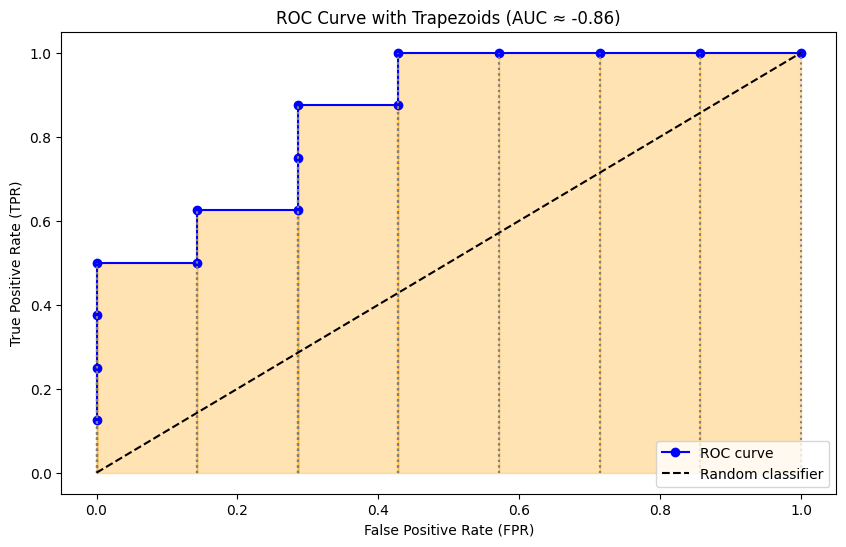

Computed AUC: -0.8571


In [4]:
# Step 1: Generate synthetic data
np.random.seed(0)
n = 15 # How many datapoints
# Generate feature values that loosely correlate with the label
feature_values = np.linspace(0, 1, n) + np.random.normal(0, 0.1, n)
# Set labels with a general trend: higher values are more likely to be labeled 1
labels = (feature_values + np.random.normal(0, 0.2, n) > 0.5).astype(int)

# Sort data based on the feature values to simulate model score sorting
sorted_indices = np.argsort(feature_values)
feature_values = feature_values[sorted_indices]
labels = labels[sorted_indices]

# Step 2: Calculate TPR and FPR for ROC without sklearn's built-in functions
# Calculate the true positive rate (TPR) and false positive rate (FPR)
def compute_roc_points(feature_values, labels):
    thresholds = np.unique(feature_values)
    tpr_list = []
    fpr_list = []
    for thresh in thresholds:
        # Classify points based on threshold
        predictions = feature_values >= thresh
        TP = np.sum((predictions == 1) & (labels == 1))
        FP = np.sum((predictions == 1) & (labels == 0))
        FN = np.sum((predictions == 0) & (labels == 1))
        TN = np.sum((predictions == 0) & (labels == 0))
        
        # Calculate TPR and FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    
    return np.array(fpr_list), np.array(tpr_list)

# Get FPR and TPR points
fpr, tpr = compute_roc_points(feature_values, labels)

# Step 3: Calculate AUC via the trapezoidal rule and plot each trapezoid
def plot_roc_with_trapezoids(fpr, tpr):
    auc = 0.0
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', marker='o', label='ROC curve')
    
    # Calculate area under the curve using trapezoids and plot them
    for i in range(1, len(fpr)):
        x1, x2 = fpr[i-1], fpr[i]
        y1, y2 = tpr[i-1], tpr[i]
        
        # Compute area of the trapezoid
        trap_area = (x2 - x1) * (y1 + y2) / 2
        auc += trap_area
        
        # Plot trapezoid for visualization
        plt.fill_between([x1, x2], [y1, y2], color='orange', alpha=0.3)
        plt.vlines(x=[x1, x2], ymin=0, ymax=[y1, y2], color='gray', linestyles='dotted')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve with Trapezoids (AUC ≈ {auc:.2f})")
    plt.legend(loc="lower right")
    plt.show()
    
    return auc

# Plot and compute AUC
auc_score = plot_roc_with_trapezoids(fpr, tpr)
print(f"Computed AUC: {auc_score:.4f}")


In [5]:
print(roc_auc_score(labels, feature_values))

0.8571428571428571


Manual computation aligns with the result obtained via formula

# Animation

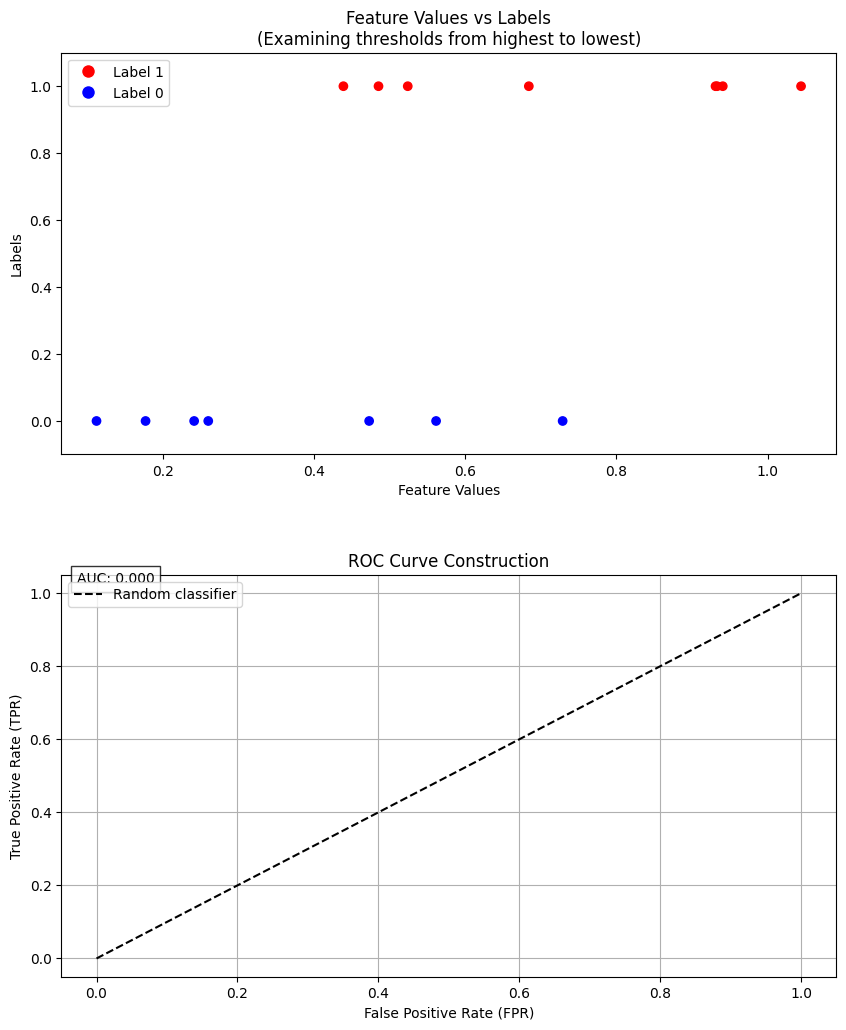

In [12]:
plt.rcParams['animation.html'] = 'jshtml'  # Enable notebook animation display

def generate_synthetic_data(n=15, seed=0):
    """Generate synthetic data with some correlation between feature and label"""
    np.random.seed(seed)
    feature_values = np.linspace(0, 1, n) + np.random.normal(0, 0.1, n)
    labels = (feature_values + np.random.normal(0, 0.2, n) > 0.5).astype(int)
    
    # Sort data based on the feature values in DESCENDING order
    sorted_indices = np.argsort(feature_values)[::-1]  # Added [::-1] for reverse order
    return feature_values[sorted_indices], labels[sorted_indices]

def compute_tpr_fpr(feature_values, labels, threshold_idx):
    """Compute TPR and FPR for a given threshold index"""
    threshold = feature_values[threshold_idx]
    predictions = feature_values >= threshold
    
    TP = np.sum((predictions == 1) & (labels == 1))
    FP = np.sum((predictions == 1) & (labels == 0))
    FN = np.sum((predictions == 0) & (labels == 1))
    TN = np.sum((predictions == 0) & (labels == 0))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    return FPR, TPR

def setup_plots():
    """Initialize the figure and axes"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    plt.subplots_adjust(hspace=0.3)
    
    # Setup top plot (Feature vs Labels)
    ax1.set_xlabel('Feature Values')
    ax1.set_ylabel('Labels')
    ax1.set_title('Feature Values vs Labels\n(Examining thresholds from highest to lowest)')
    ax1.set_ylim(-0.1, 1.1)  # Add some padding to y-axis
    
    # Setup bottom plot (ROC curve)
    ax2.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('ROC Curve Construction')
    ax2.grid(True)
    ax2.legend()
    ax2.set_xlim(-0.05, 1.05)  # Add some padding to axes
    ax2.set_ylim(-0.05, 1.05)
    
    return fig, ax1, ax2

def create_roc_animation():
    """Create and return the ROC curve animation"""
    # Generate data
    feature_values, labels = generate_synthetic_data()
    
    # Initialize plots
    fig, ax1, ax2 = setup_plots()
    
    # Create initial scatter plot with colors based on labels
    colors = ['blue' if label == 0 else 'red' for label in labels]
    scatter = ax1.scatter(feature_values, labels, c=colors)
    
    # Add legend to top plot
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', label='Label 1', markersize=10),
                      Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='blue', label='Label 0', markersize=10)]
    ax1.legend(handles=legend_elements)
    
    threshold_line = ax1.axvline(x=feature_values[0], color='black', linestyle=':', alpha=0)
    
    # Initialize storage for ROC curve points and AUC
    fpr_values = []
    tpr_values = []
    auc_score = [0]  # Use list to allow modification in nested function
    auc_text = ax2.text(0.02, 0.98, f'AUC: {auc_score[0]:.3f}', 
                        transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    def init():
        """Initialize animation"""
        threshold_line.set_alpha(0)
        return scatter, threshold_line

    def animate(frame):
        """Update animation for each frame"""
        if frame > 0:  # Skip first frame (empty plot)
            # Show threshold line
            threshold_line.set_xdata([feature_values[frame-1], feature_values[frame-1]])
            threshold_line.set_alpha(1)
            
            # Compute new TPR and FPR
            fpr, tpr = compute_tpr_fpr(feature_values, labels, frame-1)
            fpr_values.append(fpr)
            tpr_values.append(tpr)
            
            # Plot ROC curve points
            if len(fpr_values) > 1:
                # Calculate and plot trapezoid
                x1, x2 = fpr_values[-2], fpr_values[-1]
                y1, y2 = tpr_values[-2], tpr_values[-1]
                trap_area = (x2 - x1) * (y1 + y2) / 2
                auc_score[0] += trap_area
                
                # Fill trapezoid
                ax2.fill_between([x1, x2], [y1, y2], color='orange', alpha=0.3)
                # Add vertical lines
                ax2.vlines(x=[x1, x2], ymin=0, ymax=[y1, y2], 
                          color='gray', linestyles='dotted')
            
            # Plot current ROC curve
            ax2.plot(fpr_values, tpr_values, 'b-', marker='o')
            
            # Update AUC text
            auc_text.set_text(f'AUC: {auc_score[0]:.3f}')
        
        return scatter, threshold_line

    # Create animation
    anim = FuncAnimation(fig, animate, init_func=init,
                        frames=len(feature_values)+1, # +1 for initial empty frame
                        interval=1000, # 1 second between frames
                        blit=True, repeat=False)
    
    return anim

# Create and display animation
anim = create_roc_animation()

# Ideas

Animation / MP4 like visual showcasing how the:
- Data points are sorted and examined in decreasing order
- TPR + FPR computed at each point (with each point functioning as one "threshold")
- **TPR / FPR** points computed on the ROC curve
- Trapezoid computed

A video of two plots: one above and one below. Plot above is the data points on a feature-label axes. Plot below is the ROC curve. 
- At every tick one data point is examined
- Move a vertical line to indicate the datapoints examined up to this tick
- Update the ROC curve incrementally at each tick, including the new TPR / FPR point + trapezoid

some connection to Gini coeffictient? 
